Libraries ans installations


In [19]:
!pip install rasterio
!pip install fsspec s3fs gcsfs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 61.4 MB/s eta 0:00:00


In [20]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
import tarfile
import random
from joblib import Parallel, delayed
from PIL import Image
import numpy as np
from time import time
from pathlib import Path
from google.colab import drive
import rasterio
from matplotlib import pyplot as plt
import seaborn as sns

Run the !wget to download the Crop harvest dataset, this contains about 25g, so part of the proces will be to extract 1g of random images

In [ ]:

!wget https://zenodo.org/record/10251170/files/eo_data.tar.gz?download=1 -O eo_data.tar.gz

--2025-07-09 03:01:20--  https://zenodo.org/record/10251170/files/eo_data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10251170/files/eo_data.tar.gz [following]
--2025-07-09 03:01:21--  https://zenodo.org/records/10251170/files/eo_data.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 26723356856 (25G) [application/octet-stream]
Saving to: ‘eo_data.tar.gz’

eo_data.tar.gz      100%[===================>]  24.89G  23.5MB/s    in 72m 48s 

2025-07-09 04:14:09 (5.84 MB/s) - ‘eo_data.tar.gz’ saved [26723356856/26723356856]



This line of the code creates a file called crop_harvest which opens the .tar to unzip file and extract the tif images, the code pics the ammount of .tif images randomly until it reaches 1gb

In [ ]:


# Ruta de salida
output_dir = Path("CropHarvest_extract")
output_dir.mkdir(parents=True, exist_ok=True)

# Límite de extracción: 1 GB
size_limit = 1 * 1024**3  # 1 GB en bytes
total_bytes = 0
count = 0

# Abrir el archivo .tar.gz y extraer archivos .tif secuencialmente
with tarfile.open("eo_data.tar.gz", "r:gz") as tar:
    for member in tar:
        if not member.isfile() or not member.name.endswith(".tif"):
            continue

        if total_bytes + member.size > size_limit:
            break

        tar.extract(member, path=output_dir)
        total_bytes += member.size
        count += 1

print(f"{count} Extraction done. Total: {total_bytes / (1024 ** 2):.2f} MB")


✅ 3070 archivos extraídos. Total: 1023.67 MB


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing with joblib using Crobharvest DS

In this part, Data analysis will be processed with CropHarvest with the intention to measure the parallel processing time.



Creating a list with .tif images

In [11]:
file_path = "/content/drive/MyDrive/CropHarvest_extract/eo_data"
routes = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(".tif")]


# Statistics

Rasterio is used in a GeoTiff .tiff images.

This code takes the file path and reads the RGB colors of the images to take statistics as the GEOTIFF images also contain spatial data.

In [23]:
def img_preprocessing(path: str) -> dict:
    filename = Path(path).name

    try:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(float)

        return {
            "file": filename,
            "mean": np.nanmean(arr),
            "std":  np.nanstd(arr),
            "min":  np.nanmin(arr),
            "max":  np.nanmax(arr),
            "shape": arr.shape
        }

    except Exception as e:
        return {
            "file": filename,
            "mean": None,
            "std":  None,
            "min":  None,
            "max":  None,
            "shape": None,
            "error": str(e)
        }


# Parallel execution

This parallel job would be applied in n_job in n nucleus, in this case -1 indicades that the process will run in all available routes in the moment the code is executed.

Then, it'll include all the results in a DF including errors, this to check if there's any part of the preprocessing made above that the libraries could not process due to the kind of images we are using.

This code uses Joblib’s Parallel and delayed to apply the function img_preprocessing to each path in the list routes in parallel. The delayed wrapper ensures that each function call is queued for parallel execution instead of being executed immediately. Parallel(n_jobs=-1) runs as many tasks in parallel as there are CPU cores available. This approach speeds up the processing of large numbers of independent tasks like image analysis. The final result, statistics, is a list of outputs in the same order as the input paths.

In [27]:
start_time = time()

statistics = Parallel(n_jobs=-1)(
    delayed(img_preprocessing)(path) for path in routes
)

elapsed = time() - start_time
print(f"Parallel preprocessing in  {elapsed:.2f} s.")

# Results to DF
df_statistics = pd.DataFrame(statistics)
df_statistics.head()


Parallel preprocessing in  103.51 s.


,file,mean,std,min,max,shape,error
0,234-ethiopia_2020-02-07_2021-02-01.tif,-15.134761,1.798779,-21.686744,-10.121315,"(17, 17)",NaN
1,245-ethiopia_2020-02-07_2021-02-01.tif,-15.291374,1.384763,-20.250263,-11.684926,"(18, 17)",NaN
2,538-ethiopia_2020-02-07_2021-02-01.tif,-9.775265,1.785382,-16.077098,-6.173658,"(18, 17)",NaN
3,698-ethiopia_2020-02-07_2021-02-01.tif,-12.070617,2.255461,-20.197721,-7.952914,"(18, 17)",NaN
4,246-togo_2019-02-06_2020-02-01.tif,-12.455573,2.140130,-17.560089,-6.417751,"(17, 18)",NaN


# Mean values consistently negative

Most images have average values between –15 and –5, indicating that the pixel values themselves are negative due to how the satellite bands are scaled.

**Central concentration around –10**

There's a noticeable peak around –10, suggesting that most images have similar negative mean values after preprocessing.

**Longer left tail below –20**

Some images have means as low as –25 or –30, indicating darker or sparser reflectance in those particular bands or scenes.

# Why mean values are negative:
According to GIS experts, it's common in certain surface reflectance products (e.g. Landsat) to have negative pixel values for non-vegetated surfaces—like water, clouds, rocks, or masked areas—because they reflect more in red than near-infrared. These values don't indicate errors; rather, they reflect how the data were retrieved or preprocessed.

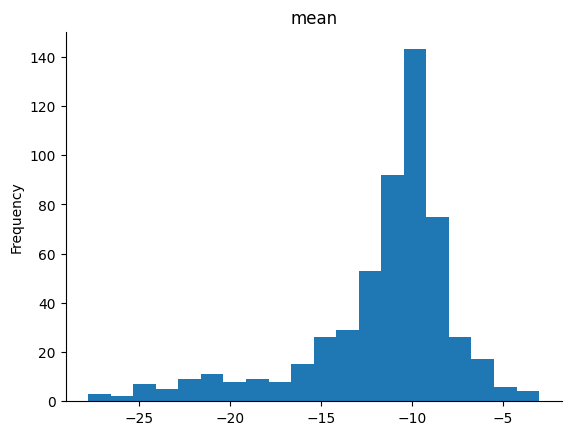



# NDVI estimation

NDVI (Normalized Difference Vegetation Index)

Is a remotely‑sensed indicator used to assess the density and health of green vegetation. It compares the reflectance of near‑infrared (NIR) light—strongly reflected by healthy plants—with red light, which is strongly absorbed by chlorophyll, via the formula:

*NDVI = (NIR – Red) / (NIR + Red)*

**The index ranges from –1 to +1:**

Low (near 0 or negative): water, bare soil, or built-up areas

High (0.6–0.9): dense, healthy vegetation

**NDVI is widely utilized in agriculture, forestry, land monitoring, and climate studies to track plant vitality, detect drought, and optimize resource use.**

In [37]:
def ndvi_est(path: str) -> dict:
    file = Path(path).name

    try:
        with rasterio.open(path) as src:
            red, nir = (src.read(i).astype(float) for i in (1, 2))
            ndvi = (nir - red) / (nir + red + 1e-5)

        return {
            "file": file,
            "ndvi_mean": np.nanmean(ndvi),
            "ndvi_std":  np.nanstd(ndvi)
        }

    except Exception as e:
        return {
            "file": file,
            "ndvi_mean": None,
            "ndvi_std":  None,
            "error":     str(e)
        }


# Parallel execution with Joblib

In [38]:
start_time = time()

ndvi = Parallel(n_jobs=-1)(
    delayed(img_preprocessing)(path) for path in routes
)

elapsed = time() - start_time
print(f"Parallel preprocessing in  {elapsed:.2f} s.")

# Results to DF
df_ndvi = pd.DataFrame(ndvi)
df_ndvi.head()


Parallel preprocessing in  111.34 s.


,file,mean,std,min,max,shape,error
0,234-ethiopia_2020-02-07_2021-02-01.tif,-15.134761,1.798779,-21.686744,-10.121315,"(17, 17)",NaN
1,245-ethiopia_2020-02-07_2021-02-01.tif,-15.291374,1.384763,-20.250263,-11.684926,"(18, 17)",NaN
2,538-ethiopia_2020-02-07_2021-02-01.tif,-9.775265,1.785382,-16.077098,-6.173658,"(18, 17)",NaN
3,698-ethiopia_2020-02-07_2021-02-01.tif,-12.070617,2.255461,-20.197721,-7.952914,"(18, 17)",NaN
4,246-togo_2019-02-06_2020-02-01.tif,-12.455573,2.140130,-17.560089,-6.417751,"(17, 18)",NaN


# This scatter plot compares the minimum (min) and maximum (max) pixel values from each GeoTIFF file after preprocessing.

**Strong Positive Correlation**

The points form an upward-sloping cloud, indicating that files with lower minimum pixel values tend to also have lower maximum values, and vice versa.

**Narrow Vertical Spread**

For each minimum value, there's only modest variation in maximum values—this suggests internal consistency within each image.

**All Pixel Values Are Negative**

Seeing both min and max in the negative range (e.g. –25 to –5) hints at unusual data scaling—perhaps it’s raw satellite indices, fractional values, or data centered around zero.

**One Outlier at max ≈ +7**

A point significantly above the trend suggests one image has much higher pixel values relative to others. It could be an anomaly or include bright features (e.g. desert, clouds).

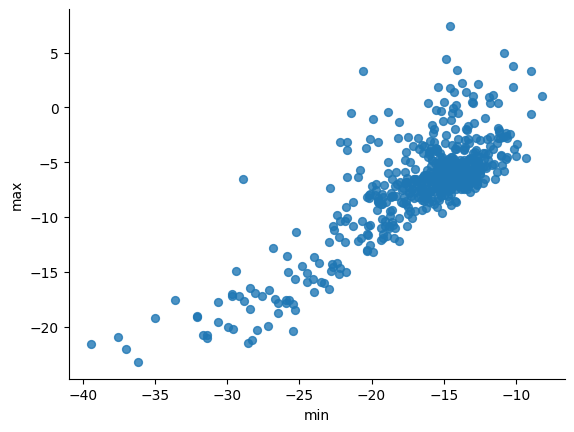

To download plant village dataset, we need a token from Kaggle API

# Steps needed in both environments: locally and cloud


1.   pip install kaggle
2.   go to: https://www.kaggle.com/settings
3.   “Create New API Token” It'll download a kaggle.json file

# Execute this if locally

To add the API in a safe place for MAC or linux systems:

mkdir -p ~/.kaggle

mv /ruta/del/archivo/kaggle.json ~/.kaggle/

chmod 600 ~/.kaggle/kaggle.json


for windows:

mkdir %USERPROFILE%\.kaggle

move "C:\ruta\a\kaggle.json" "%USERPROFILE%\.kaggle\"


note: if done in colab or cloud: proceed with the code line: #from google colab ....

This is done in colab so if you are running it locally, ignore the #from google colab import files code line

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avahlava","key":"6467628ab9e86baeea796e58501bf9c2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

This code line will download de .zip file and unzip it.

In [ ]:
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plantvillage

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 641M/658M [00:06<00:00, 172MB/s]
100% 658M/658M [00:06<00:00, 101MB/s]


In [ ]:
import os

base_path = "plantvillage"
classes = os.listdir(base_path)



Clases disponibles: 2
['PlantVillage', 'plantvillage']


The Dataset will download in different files depending on the plant/vegetable, this DF can be use to train, but for testing purposes, the next code will create a flat dataset that contains all the images.

In [ ]:
# File route
source_dir = "plantvillage"

# Destined file
dest_dir = "flat_dataset_PlantVillage"
os.makedirs(dest_dir, exist_ok=True)

# Lista para guardar: [nuevo_nombre, clase_original]
records = []
counter = 0

# create a loop to check every file
for img_file in os.listdir(class_path):
    src = os.path.join(class_path, img_file)

    if os.path.isdir(src):
        continue

    new_filename = f"image_{counter:05d}.jpg"
    dst = os.path.join(dest_dir, new_filename)

    shutil.copy2(src, dst)
    records.append([new_filename, class_name])
    counter += 1

# Safe labes to: labels.csv
df = pd.DataFrame(records, columns=["filename", "label"])
df.to_csv(os.path.join(dest_dir, "labels.csv"), index=False)

print(f"Images copied {counter} to  {dest_dir} and labels saved to: labels.csv")


Images copied 0 to  flat_dataset_PlantVillage and labels saved to: labels.csv
